<a href="https://colab.research.google.com/github/PhichamonS/Heart_Abnormality_Classification/blob/main/Model_training_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Requirement


In [1]:
!pip install -q biosppy
!pip install -q astropy
!pip install -q neurokit2
!pip install -q tensorflow
!pip install -q peakutils

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import biosppy as bp
import scipy.io.wavfile
import struct

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Loading data

In [3]:
# Set path folder
file_path = '/content/drive/MyDrive/Colab_Notebooks/ML/Project/Data/'
path_processed = '/content/drive/MyDrive/Colab_Notebooks/ML/Project/Processed_data/'

fs = 2000       # Define sampling frequency
flag_processed = 0

if flag_processed == 0:
  ecg_all = np.load(path_processed + 'ecg_all.npy', allow_pickle=True)
  pcg_all = np.load(path_processed + 'pcg_all.npy', allow_pickle=True)
  label_all = np.load(path_processed + 'label_all.npy', allow_pickle=True)

else:
  ecg_all = []
  pcg_all = []
  label_all = []

  # Get file for the RECORDS
  path_to_file = file_path + "RECORDS"
  with open(path_to_file) as f:
      contents = f.readlines()

  for content in contents:
    # Get filename
    filename = content[:-1]

    # ECG data: Define the binary structure format
    ecg_file = file_path + filename + '.dat'
    wav_file = file_path + filename + '.wav'

    ecg = []
    pcg = []
    try:
        # Read ECG data
        with open(ecg_file, 'rb') as file:
          binary_data = file.read()

          # Now unpack all data at once
          data = struct.iter_unpack('h', binary_data)
          for item in data:
            ecg.append(item[0])

        # Read PCG data
        fs, pcg = scipy.io.wavfile.read(wav_file)

        # Get same lenght of signal
        if (len(pcg)>= 40000 and len(ecg)>= 40000) :
          pcg = pcg[5000:40000]
          ecg = ecg[5000:40000]

          # Read classification label
          with open(file_path + filename + '.hea') as f:
              data_info = f.readlines()
              label = 0 if data_info[-1][2:-1] == 'Normal' else 1

          pcg_all.append(pcg)
          ecg_all.append(ecg)
          label_all.append(label)
        else:
          continue

    except:
        continue

  n = np.shape(np.array(pcg_all))[1]
  timevec = np.arange(0, n) / fs

  np.save(path_processed + 'ecg_all.npy', ecg_all)
  np.save(path_processed + 'pcg_all.npy', pcg_all)
  np.save(path_processed + 'label_all.npy', label_all)


# 3. Data processing

In [4]:
from scipy.signal import resample_poly, resample, hilbert, butter, filtfilt,stft
from matplotlib.mlab import specgram
from pywt import downcoef
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def get_envelope_features(signal,fs):
    # Filter Design
    order = 2
    passBand = np.array([25, 400])

    # Band-Pass filtering of the PCG:
    filtered,fs,params = bp.signals.tools.filter_signal(signal,'butter','bandpass',order,passBand,fs)

    # spike removal
    filtered = spike_removal(np.transpose(filtered),fs)
    filtered = resample(filtered,int((1000/fs)*len(filtered)))

    # homomorphic envelope
    fs = 1000
    e1 = homomorphic_envelope(filtered,fs)
    downs_e1 = resample_poly(e1,1,fs/50)
    downs_e1, = bp.signals.tools.normalize(downs_e1)
    downs_e1[0] = downs_e1[1]

    # hilbert envelope
    e2 = hilbert_envelope(filtered)
    downs_e2 = resample_poly(e2,1,fs/50)
    downs_e2, = bp.signals.tools.normalize(downs_e2)
    downs_e2[0] = downs_e2[1]

    # power spectral density envelope
    e3 = psd_envelope(filtered, fs)
    downs_e3 = resample(e3,len(downs_e1))
    downs_e3, = bp.signals.tools.normalize(downs_e3)
    downs_e3[0] = downs_e3[1]

    # wavelet envelope
    e4 = wavelet_envelope(filtered)
    e4 = e4[:len(e1)]
    downs_e4 = resample_poly(e4,1,fs/50)
    downs_e4, = bp.signals.tools.normalize(downs_e4)
    downs_e4[0] = downs_e4[1]

    envelopes = np.zeros((len(downs_e1),4))
    envelopes[:,0] = downs_e1
    envelopes[:,1] = downs_e2
    envelopes[:,2] = downs_e3
    envelopes[:,3] = downs_e4

    return envelopes

def homomorphic_envelope(x, fs=1000, f_LPF=8, order=1):
    b, a = butter(order, 2 * f_LPF / fs, 'low')
    he = np.exp(filtfilt(b, a, np.log(np.abs(hilbert(x)))))

    # Remove spurious spikes in first sample:
    he[0] = he[1]

    return he

def hilbert_envelope(x):
    he = np.abs(hilbert(x))

    return he

def psd_envelope(x, fs):
    spectrum,frequencies,t = specgram(x,NFFT=int(fs/40),Fs=fs,window=np.hamming(fs/40),noverlap=int(fs/80),mode='psd');

    low_limit_position = np.argwhere(frequencies==40)[0][0]
    high_limit_position = np.argwhere(frequencies==80)[0][0]
    psd = np.mean(spectrum[low_limit_position:high_limit_position+1,:],axis=0);

    return psd

def wavelet_envelope(x):
    coeffs = downcoef('d',x, 'rbio3.9', level=3)
    coeffs = np.repeat(coeffs,2**3)

    d = (len(coeffs) - len(x))/2
    first =  int(np.floor(d))
    last = int(len(coeffs) - np.ceil(d))

    coeffs = coeffs[first:last]
    wavelet_feature = abs(coeffs)

    return wavelet_feature

def spike_removal(signal,fs):

    window_size = round(fs/2)
    trailing_samples = len(signal)%window_size


    if trailing_samples >  0:
        sampleframes = np.reshape(signal[:-trailing_samples],(window_size,int(len(signal[:-trailing_samples])/window_size)))
    else:
        sampleframes = np.reshape(signal,(window_size,int(len(signal)/window_size)))


    MAAs = np.amax(abs(sampleframes),axis=0);

    while len(np.argwhere(MAAs>np.median(MAAs)*3)) > 0:

        window_num = np.argmax(MAAs)

        if np.size(window_num)>1:
            window_num = window_num[0]

        spike_position = np.argmax(abs(sampleframes[:,window_num]));

        if np.size(spike_position)>1:
            spike_position = spike_position[0]


        zero_crossings = np.concatenate((abs(np.diff(np.sign(sampleframes[:,window_num])))>1,np.array([False])),axis=0)
        try:
            spike_start = max(np.concatenate((np.array([0]), np.argwhere(zero_crossings[0:spike_position+1]==1)[-1])))
        except:
            spike_start = 0

        zero_crossings[0:spike_position+1] = 0

        try:
            spike_end = min(np.concatenate((np.argwhere(zero_crossings==1)[0], np.array([window_size-1]))))
        except:
            spike_end = window_size -1

        sampleframes[spike_start:(spike_end+1),window_num] = 0.0001;

        MAAs = np.amax(abs(sampleframes),axis=0);

    despiked_signal = np.reshape(sampleframes, (np.size(sampleframes),1));
    despiked_signal = np.concatenate((despiked_signal.ravel(),signal[len(despiked_signal):]),axis=0);

    return despiked_signal


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')

    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)

    return y

def downsample_signal(signal, original_fs, target_fs, axis = 0):
    # Calculate the number of samples in the downsampled signal
    num_samples = int(len(signal) * target_fs / original_fs)

    # Resample the signal
    downsampled_signal = resample(signal, num_samples, axis = axis)

    return downsampled_signal

def get_instanteneous_frequency(signal,fs):

  analytic_signal = hilbert(signal)
  amplitude_envelope = np.abs(analytic_signal)
  instantaneous_phase = np.unwrap(np.angle(analytic_signal))
  instantaneous_frequency = np.insert((np.diff(instantaneous_phase) /(2.0*np.pi) * fs),0,0)
  instantaneous_frequency, = bp.signals.tools.normalize(instantaneous_frequency)

  return instantaneous_frequency

def pre_process_ECG(signal,fs):
  bandpass = np.array([0.5, 100])
  # filter signal with bandpass
  signal,fs,params = bp.signals.tools.filter_signal(signal,'butter','bandpass',2, bandpass, fs)

  # downsample signal
  fs_downsamp = 50
  signal_downasmp = downsample_signal(signal,fs,fs_downsamp)

  # Get time-freq signal
  instantaneous_frequency = get_instanteneous_frequency(signal_downasmp,fs_downsamp)

  # norm signal
  signal_norm, = bp.signals.tools.normalize(signal_downasmp)

  process_ECG = np.zeros((len(signal_norm),2))
  process_ECG[:,0] = signal_norm
  process_ECG[:,1] = instantaneous_frequency

  return process_ECG



In [5]:
# Initialize lists to store processed signals
X_pcg = []
X_ecg = []

fs =2000
scaler = MinMaxScaler()

# Loop through the signals
for i in range(len(pcg_all)):
    # Process PCG
    # pcg_temp = butter_bandpass_filter(pcg_all[i], lowcut=20, highcut=450, fs=fs, order=2)
    # pcg_temp = bp.signals.pcg.homomorphic_filter(signal=pcg_all[i], sampling_rate=fs, f_LPF=8, order=2)[0]
    # pcg_temp = scaler.fit_transform(pcg_temp.reshape(-1,1)).flatten()
    # pcg_temp = nk.standardize(pcg_temp)
    pcg_temp = get_envelope_features(signal=pcg_all[i], fs=fs)
    X_pcg.append(pcg_temp)

    # Process ECG
    # ecg_temp = butter_bandpass_filter(ecg_all[i], lowcut=0.5, highcut=50, fs=fs, order=2)
    # ecg_temp = scaler.fit_transform(ecg_temp.reshape(-1,1)).flatten()
    # ecg_temp = nk.standardize(ecg_temp)
    ecg_temp = pre_process_ECG(signal =ecg_all[i], fs=fs)
    X_ecg.append(ecg_temp)

# Convert lists to numpy arrays
X_pcg = np.array(X_pcg)
X_ecg = np.array(X_ecg)
y = np.array(label_all)

np.save(path_processed + 'ecg_processed.npy', X_ecg)
np.save(path_processed + 'pcg_processed.npy', X_pcg)

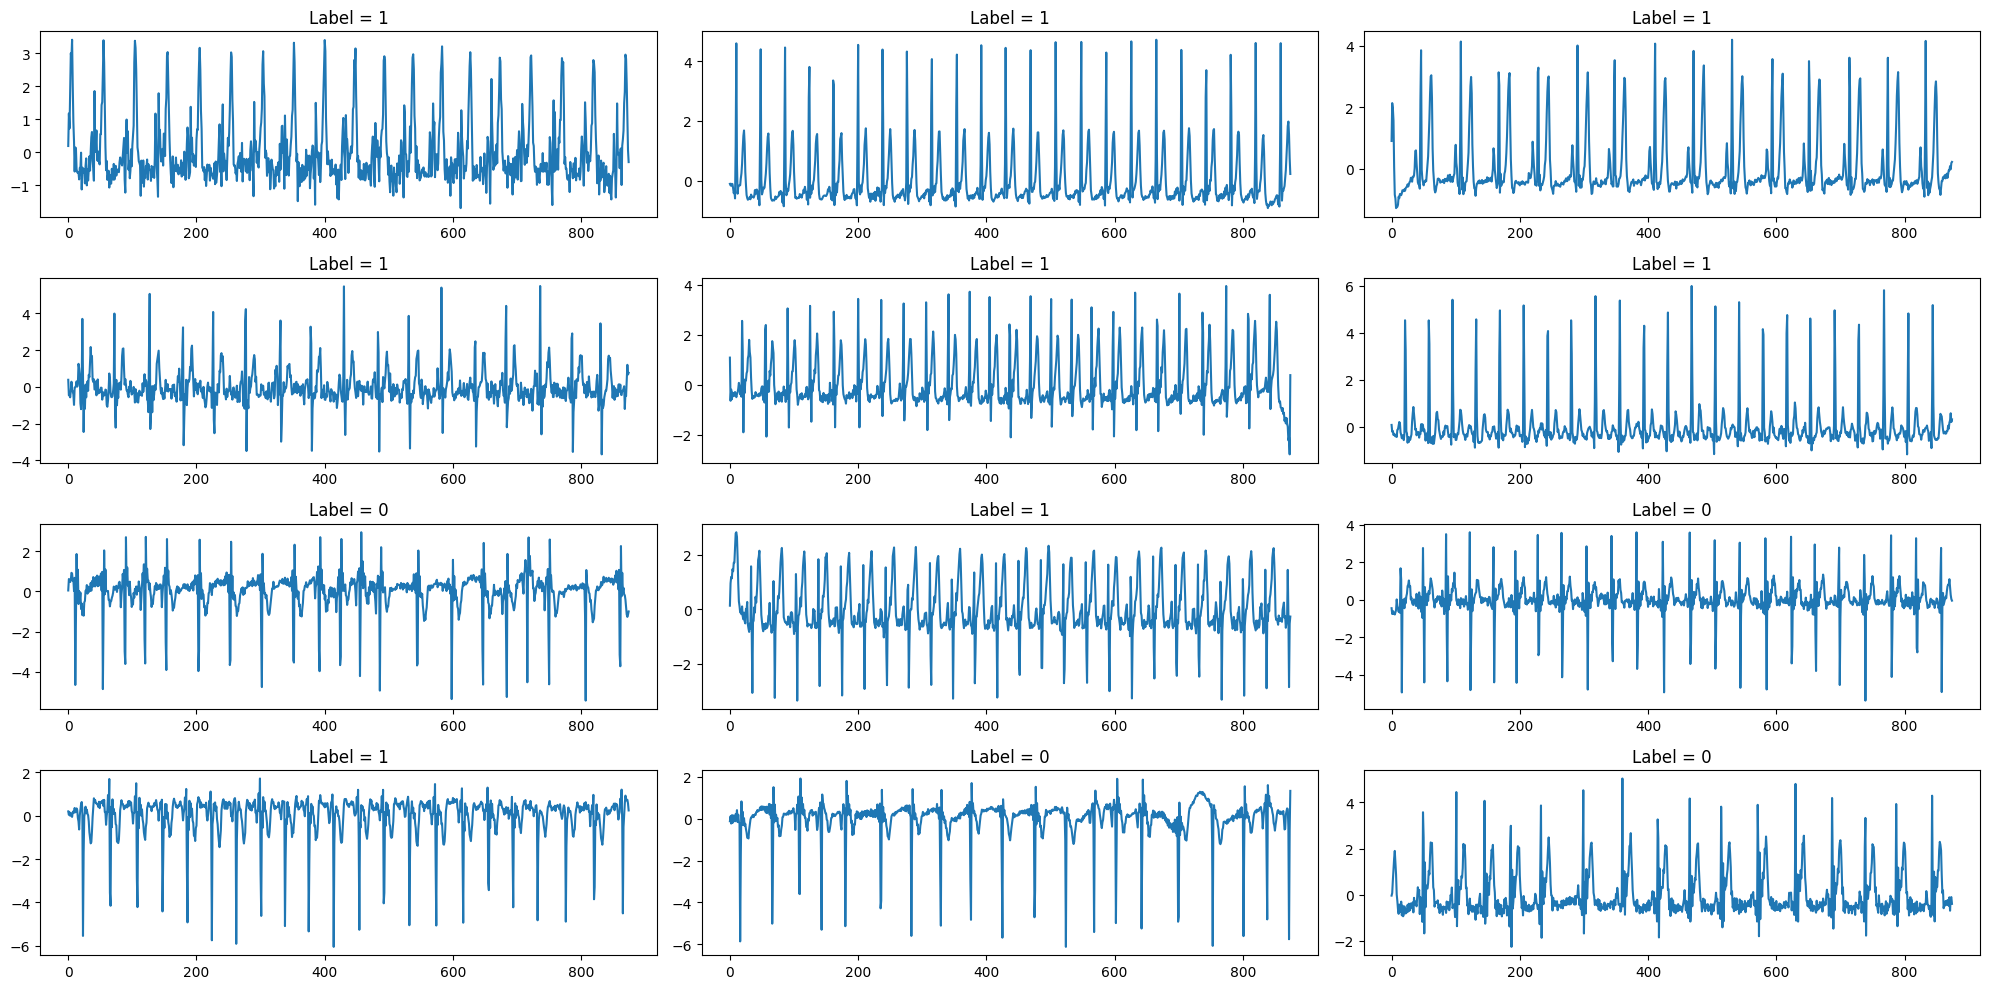

In [6]:
# Create a 2x3 grid of subplots (adjust according to the number of plots needed)
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()

# Plot in each subplot
for idx, i in enumerate(range(0,12)):

    ecg_temp,fs,params = bp.signals.tools.filter_signal(ecg_all[i],'butter','bandpass',2,np.array([0.5, 100]), 2000)
    ecg_temp = downsample_signal(ecg_temp, 2000, 50)
    ecg_temp, = bp.signals.tools.normalize(ecg_temp)
    axs[idx].plot(ecg_temp)
    axs[idx].set_title('Label = ' + str(label_all[i]))  # Set the title

# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()

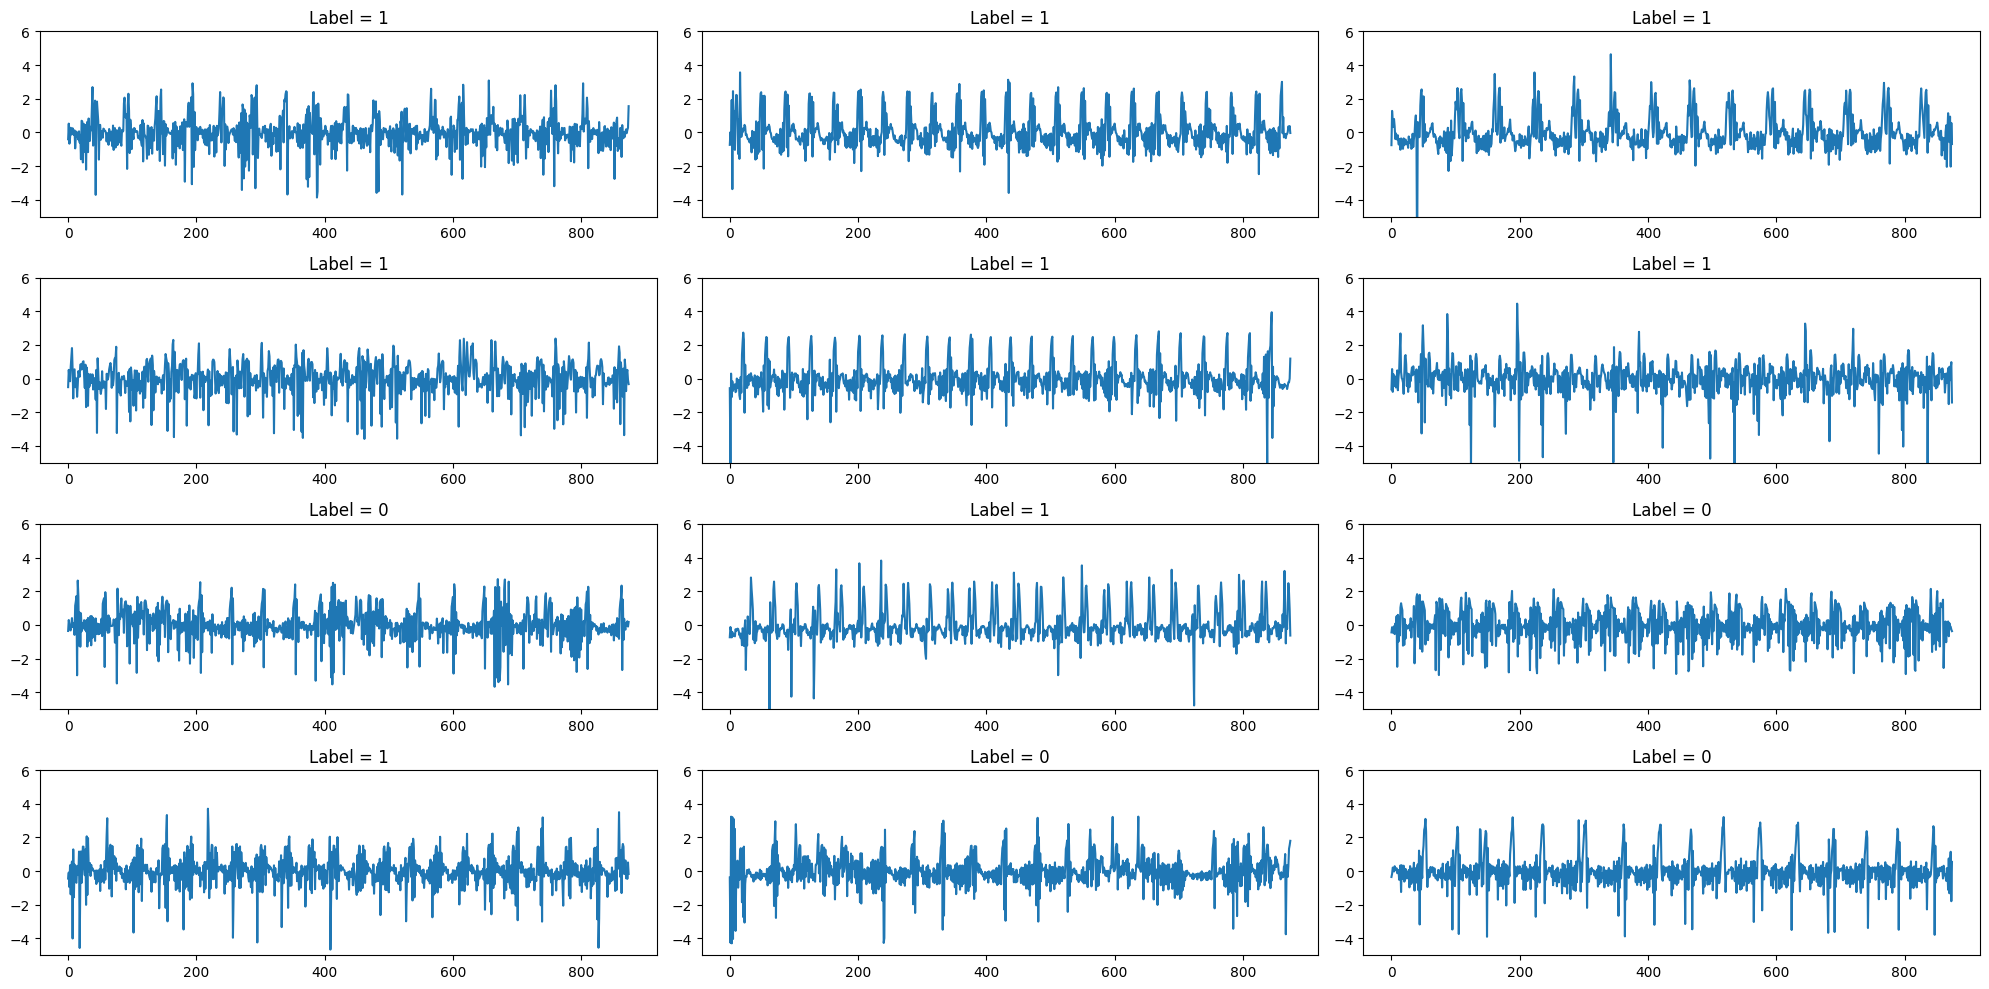

In [8]:
# Create a 2x3 grid of subplots (adjust according to the number of plots needed)
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()
y_limit = (-5,6)

# Plot in each subplot
for idx, i in enumerate(range(0,12)):
    ecg_temp,fs,params = bp.signals.tools.filter_signal(ecg_all[i],'butter','bandpass',2,np.array([0.5, 100]), 2000)
    ecg_temp = downsample_signal(ecg_temp,2000,50)
    analytic_signal = hilbert(ecg_temp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.insert((np.diff(instantaneous_phase) /
                              (2.0*np.pi) * 50),0,0)


    instantaneous_frequency, = bp.signals.tools.normalize(instantaneous_frequency)

    axs[idx].plot(instantaneous_frequency)
    axs[idx].set_title('Label = ' + str(label_all[i]))  # Set the title
    axs[idx].set_ylim(y_limit)

# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()

# 4. Preparing input

### 4.1 Train-Test split

In [9]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Stack along the last axis
X_combined = np.concatenate((X_ecg, X_pcg), axis=2)
# y =  to_categorical(y, num_classes = 2)
try:
  y = y.reshape(-1,1)
except:
  y = np.array(y).reshape(-1,1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

print(
    "Class distribution:\n"
    f"  Train -> 0: {np.sum(y_train == 0)}, 1: {np.sum(y_train == 1)}\n"
    f"  Test  -> 0: {np.sum(y_test == 0)}, 1: {np.sum(y_test == 1)}"
)

Class distribution:
  Train -> 0: 95, 1: 223
  Test  -> 0: 20, 1: 60


### 4.2 Segmentation: slice into smaller window

In [10]:
# Function to segment a single signal
def segment_signal(signal, segment_length=2000, overlap=0):
    """
    Segment a signal into smaller chunks of `segment_length`.

    Parameters:
    - signal: The input time-series signal (e.g., ECG or PCG) to be segmented.
    - segment_length: Length of each segment (default = 2000).
    - overlap: Number of overlapping samples between segments (default = 0).

    Returns:
    - List of segmented signals.
    """
    segments = []
    step = segment_length - overlap

    # Create segments from the signal
    for start in range(0, len(signal) - segment_length + 1, step):
        segment = signal[start:start + segment_length]
        segments.append(segment)

    return segments

# Segment the entire list of signals (both ECG and PCG)
def segment_data(signals, segment_length=2000, overlap=0):
    """
    Apply segmentation to a list of signals.

    Parameters:
    - signals: List of time-series signals (e.g., X_ecg or X_pcg).
    - segment_length: Length of each segment (default = 2000).
    - overlap: Number of overlapping samples between segments (default = 0).

    Returns:
    - List of segmented signals.
    """
    segmented_data = []

    for signal in signals:
        # Segment each signal in the list
        segmented_data.extend(segment_signal(signal, segment_length, overlap))

    return segmented_data


# Segment ECG and PCG signals
segment_length = 200 # (for 50 Hz -> 4 sec)

X_train_segmented = []
y_train_segmented = []
X_test_segmented = []
y_test_segmented = []

for i in range(0,len(X_train)):
  if y_train[i] == 0:
    overlap = 160
  else:
    overlap = 100
  X_train_segmented.extend(segment_signal(X_train[i], segment_length, overlap=overlap))
  y_train_segmented.extend([y_train[i]] * len(segment_signal(X_train[i], segment_length, overlap=overlap)))

for i in range(0,len(X_test)):
  if y_test[i] == 0:
    overlap = 160
  else:
    overlap = 80
  X_test_segmented.extend(segment_signal(X_test[i], segment_length, overlap=overlap))
  y_test_segmented.extend([y_test[i]] * len(segment_signal(X_test[i], segment_length, overlap=overlap)))

# Convert the segmented data to NumPy arrays for training
X_train_segmented = np.array(X_train_segmented)
X_test_segmented = np.array(X_test_segmented)
y_train_segmented = np.array(y_train_segmented)
y_test_segmented = np.array(y_test_segmented)

# Dataset shapes
print("Dataset shapes:")
print(f"  X_train: {X_train_segmented.shape}, y_train: {y_train_segmented.shape}")
print(f"  X_test:  {X_test_segmented.shape}, y_test:  {y_test_segmented.shape}\n")

# Class distribution
print("Class distribution:")
print(f"  Train -> 0: {np.sum(y_train_segmented == 0)}, 1: {np.sum(y_train_segmented == 1)}")
print(f"  Test  -> 0: {np.sum(y_test_segmented == 0)}, 1: {np.sum(y_test_segmented == 1)}")


Dataset shapes:
  X_train: (3176, 200, 6), y_train: (3176, 1)
  X_test:  (700, 200, 6), y_test:  (700, 1)

Class distribution:
  Train -> 0: 1615, 1: 1561
  Test  -> 0: 340, 1: 360


### Visualize Features


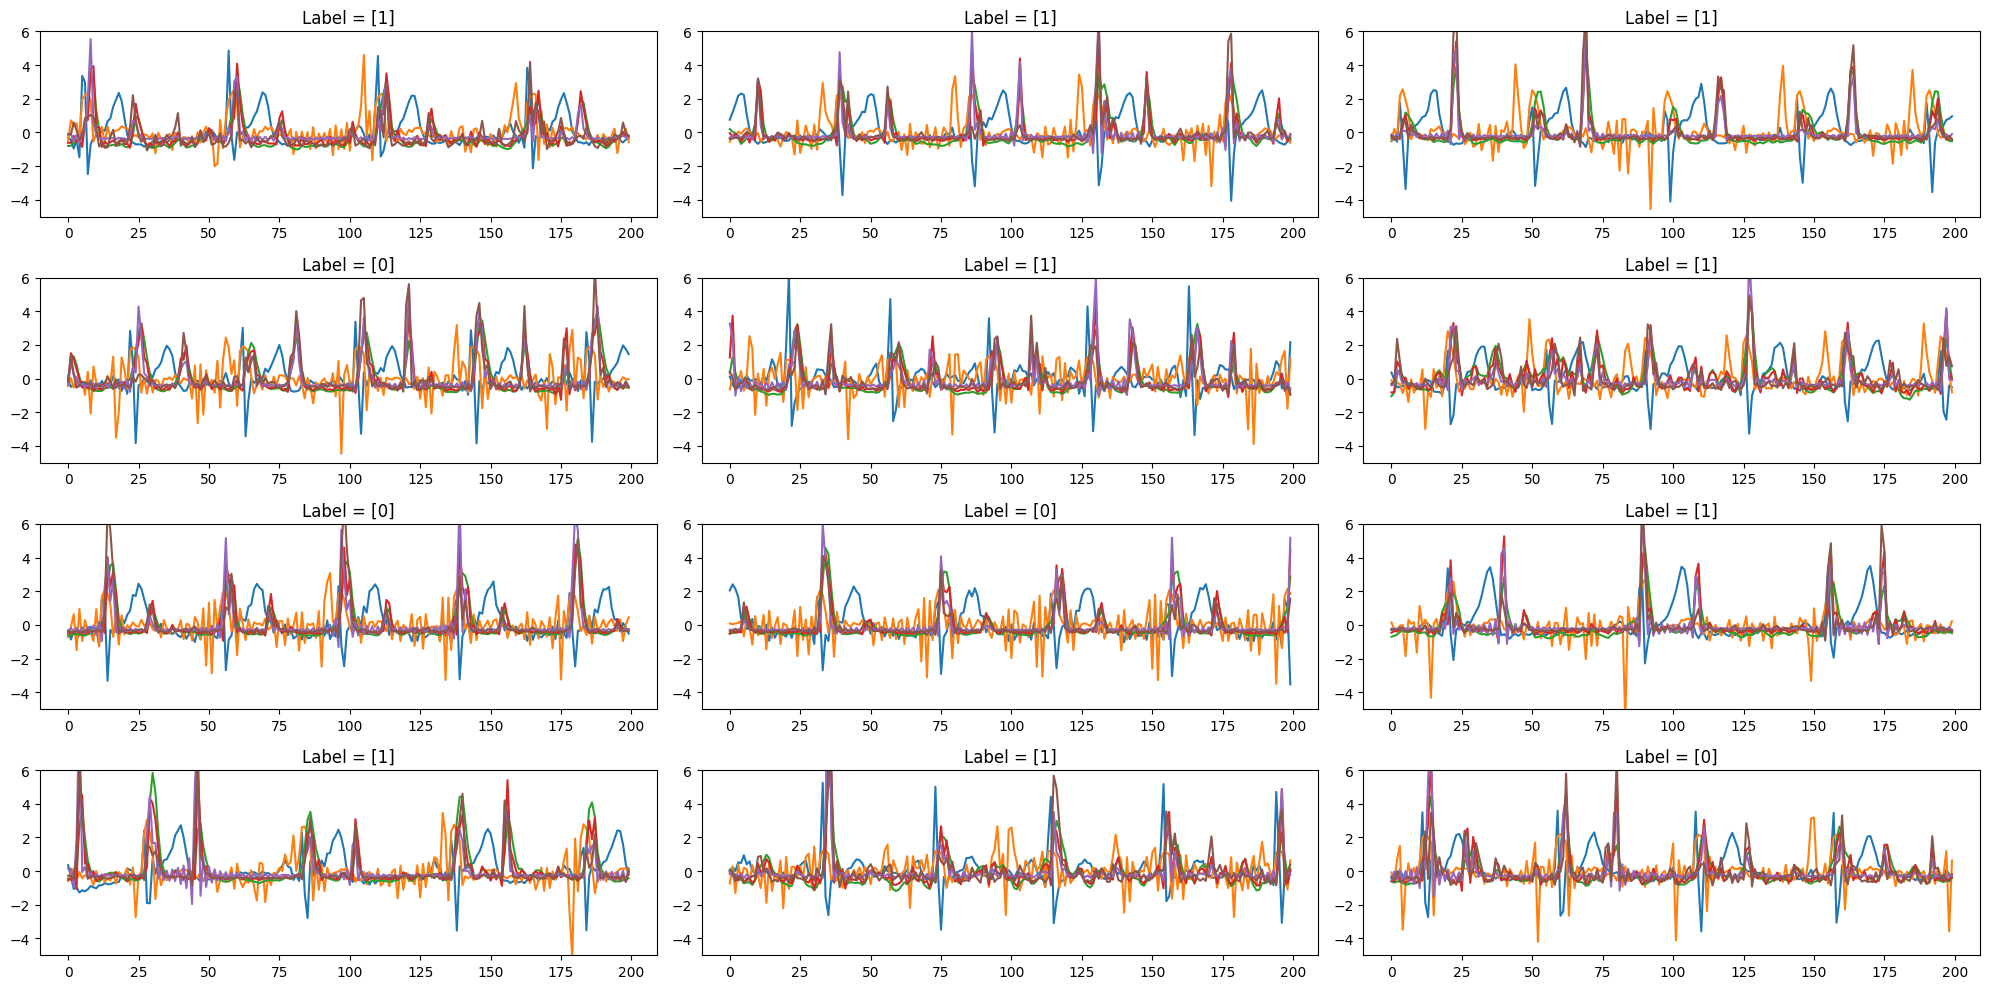

In [11]:
# Create grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()
y_limit = (-5,6)
# Plot in each subplot
for idx, i in enumerate(range(200, 320, 10)):
    axs[idx].plot(X_train_segmented[i])
    axs[idx].set_title('Label = ' + str(y_train_segmented[i]))  # Set the title
    axs[idx].set_ylim(y_limit)


# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()


Label = [0]


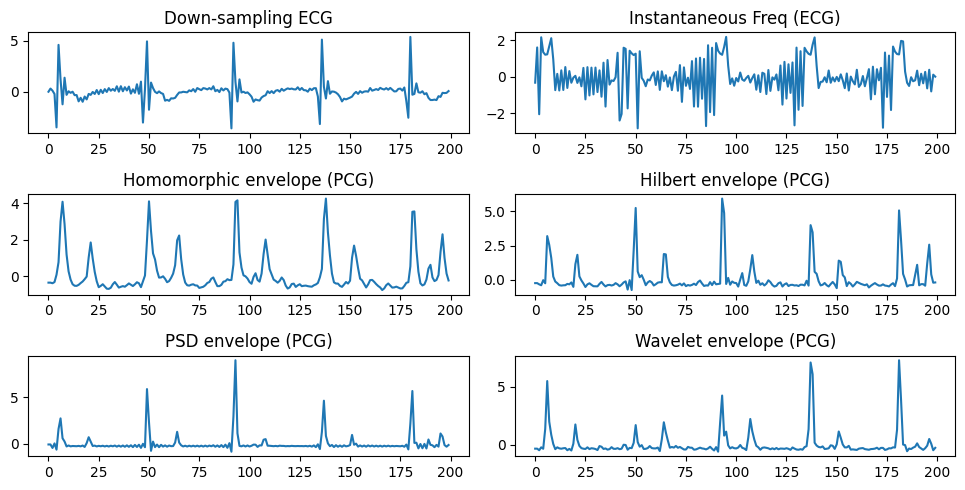

Label = [1]


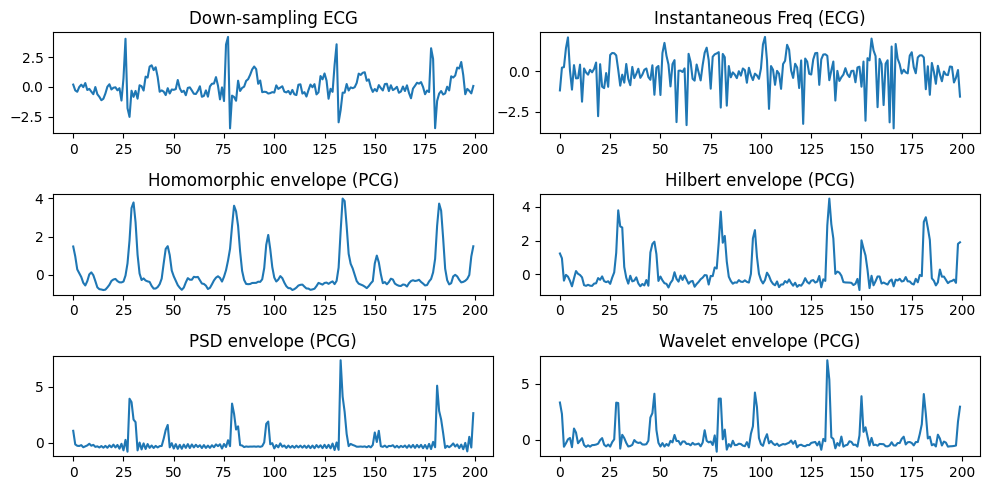

In [12]:
feat_name = [
    "Down-sampling ECG",
    "Instantaneous Freq (ECG)",
    "Homomorphic envelope (PCG)",
    "Hilbert envelope (PCG)",
    "PSD envelope (PCG)",
    "Wavelet envelope (PCG)"
]

def plot_signal_features(X, y, idx, feature_names=feat_name):

    n_features = X.shape[-1]
    n_rows, n_cols = (n_features + 1) // 2, 2

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5))
    axs = axs.flatten()

    print(f"Label = {y[idx]}")

    for k in range(n_features):
        axs[k].plot(X[idx, :, k])
        axs[k].set_title(feature_names[k])

    # Hide unused subplots (if n_features < n_rows*n_cols)
    for ax in axs[n_features:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# --- Plot examples ---
plot_signal_features(X_train_segmented, y_train_segmented, idx=7)
plot_signal_features(X_train_segmented, y_train_segmented, idx=2)


# 5. Model training


In [14]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Set seeds for reproducibility ---
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"


# --- Utility: build model ---
def build_lstm_model(input_shape, bidirectional=False):
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(64, input_shape=input_shape, return_sequences=True)))
        model.add(Bidirectional(LSTM(128, return_sequences=False)))
    else:
        model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
        model.add(LSTM(128, return_sequences=False))

    model.add(Dropout(0.3))
    model.add(Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


# --- Utility: train + evaluate ---
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    # Callbacks
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

    # Train
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=200,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        shuffle=True,
        verbose=1,
    )

    # Save
    model.save(f"{model_name}.keras")

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"[{model_name}] Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

    # Accuracy plot
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title(f"{model_name} Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Normal", "Abnormal"],
        yticklabels=["Normal", "Abnormal"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Classification report
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Abnormal"]))




### Training 1: LSTM - one direction

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5097 - loss: 1.5279 - val_accuracy: 0.5343 - val_loss: 1.5102 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5252 - loss: 1.5044 - val_accuracy: 0.5400 - val_loss: 1.4880 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5229 - loss: 1.4829 - val_accuracy: 0.5414 - val_loss: 1.4664 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5470 - loss: 1.4611 - val_accuracy: 0.5529 - val_loss: 1.4453 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5329 - loss: 1.4401 - val_accuracy: 0.5471 - val_loss: 1.4246 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5378 - loss: 1.4201 - val_accuracy: 0.5471 - val_loss: 1.4044 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5393 

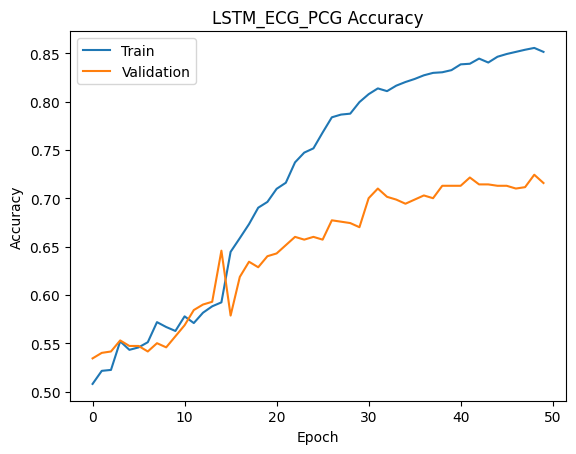

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


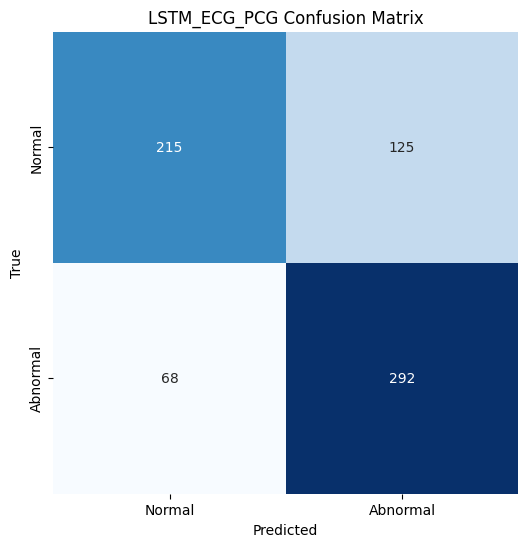

LSTM_ECG_PCG Classification Report:
              precision    recall  f1-score   support

      Normal       0.76      0.63      0.69       340
    Abnormal       0.70      0.81      0.75       360

    accuracy                           0.72       700
   macro avg       0.73      0.72      0.72       700
weighted avg       0.73      0.72      0.72       700



In [15]:
# --- Run both models ---
input_shape = (X_train_segmented.shape[1], X_train_segmented.shape[2])

# Vanilla LSTM
lstm_model = build_lstm_model(input_shape, bidirectional=False)
train_and_evaluate(lstm_model, X_train_segmented, y_train_segmented, X_test_segmented, y_test_segmented, "LSTM_ECG_PCG")



### Training 2.1: LSTM - bidirectional (ECG and PCG)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.4938 - loss: 1.7103 - val_accuracy: 0.5314 - val_loss: 1.6817 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5398 - loss: 1.6737 - val_accuracy: 0.5429 - val_loss: 1.6472 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5364 - loss: 1.6389 - val_accuracy: 0.5343 - val_loss: 1.6137 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5601 - loss: 1.6053 - val_accuracy: 0.5471 - val_loss: 1.5812 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5718 - loss: 1.5730 - val_accuracy: 0.5571 - val_loss: 1.5497 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5787 - loss: 1.5408 - val_accuracy: 0.5686 - val_loss: 1.5192 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5784 - loss: 1.5

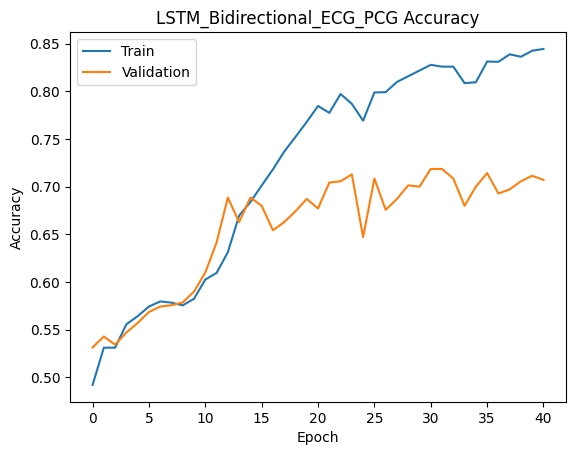

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


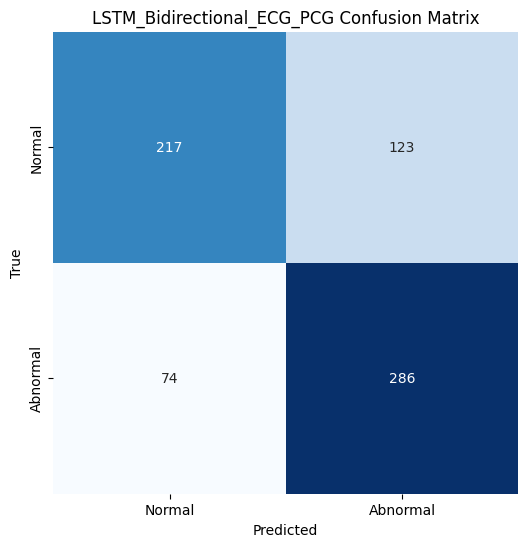

LSTM_Bidirectional_ECG_PCG Classification Report:
              precision    recall  f1-score   support

      Normal       0.75      0.64      0.69       340
    Abnormal       0.70      0.79      0.74       360

    accuracy                           0.72       700
   macro avg       0.72      0.72      0.72       700
weighted avg       0.72      0.72      0.72       700



In [16]:

# Bidirectional LSTM
bilstm_model = build_lstm_model(input_shape, bidirectional=True)
train_and_evaluate(bilstm_model, X_train_segmented, y_train_segmented, X_test_segmented, y_test_segmented, "LSTM_Bidirectional_ECG_PCG")

### Traning 2.2: LSTM - bidirectional (Only ECG)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.5099 - loss: 1.7022 - val_accuracy: 0.5743 - val_loss: 1.6738 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5584 - loss: 1.6660 - val_accuracy: 0.5886 - val_loss: 1.6390 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5724 - loss: 1.6314 - val_accuracy: 0.5757 - val_loss: 1.6053 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5687 - loss: 1.5979 - val_accuracy: 0.5686 - val_loss: 1.5726 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5496 - loss: 1.5662 - val_accuracy: 0.5786 - val_loss: 1.5410 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5722 - loss: 1.5346 - val_accuracy: 0.5843 - val_loss: 1.5101 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5735

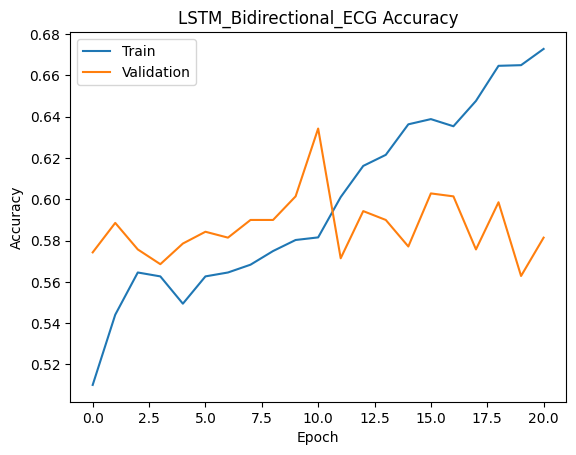

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


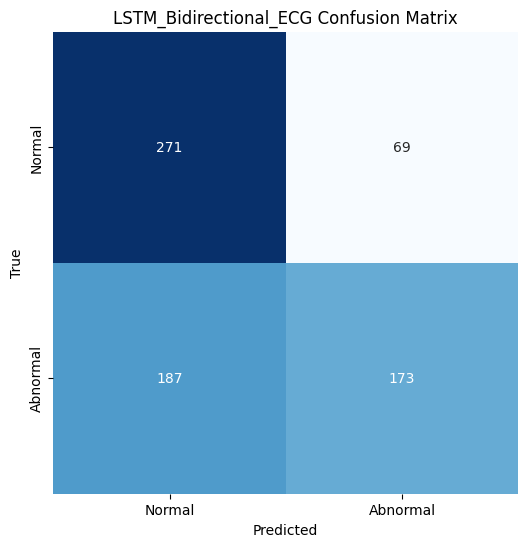

LSTM_Bidirectional_ECG Classification Report:
              precision    recall  f1-score   support

      Normal       0.59      0.80      0.68       340
    Abnormal       0.71      0.48      0.57       360

    accuracy                           0.63       700
   macro avg       0.65      0.64      0.63       700
weighted avg       0.66      0.63      0.63       700



In [19]:
feature_slice = slice(0, 2)
X_train_input = X_train_segmented[:, :, feature_slice]
X_test_input = X_test_segmented[:, :, feature_slice]
input_shape = X_train_input.shape[1:]

# Bidirectional LSTM
bilstm_model_ecg = build_lstm_model(input_shape, bidirectional=True)
train_and_evaluate(bilstm_model_ecg, X_train_input, y_train_segmented, X_test_input, y_test_segmented, "LSTM_Bidirectional_ECG")

### Training 2.3: LSTM - bidirectional (Only PCG)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.4820 - loss: 1.7049 - val_accuracy: 0.5114 - val_loss: 1.6780 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5003 - loss: 1.6695 - val_accuracy: 0.4957 - val_loss: 1.6443 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5162 - loss: 1.6349 - val_accuracy: 0.4914 - val_loss: 1.6115 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5167 - loss: 1.6016 - val_accuracy: 0.4829 - val_loss: 1.5797 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5254 - loss: 1.5698 - val_accuracy: 0.4743 - val_loss: 1.5490 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5410 - loss: 1.5386 - val_accuracy: 0.4971 - val_loss: 1.5192 - learning_rate: 1.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5424 - loss: 1.

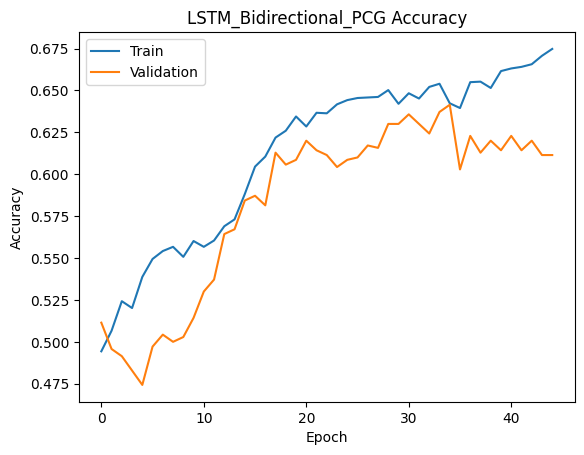

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


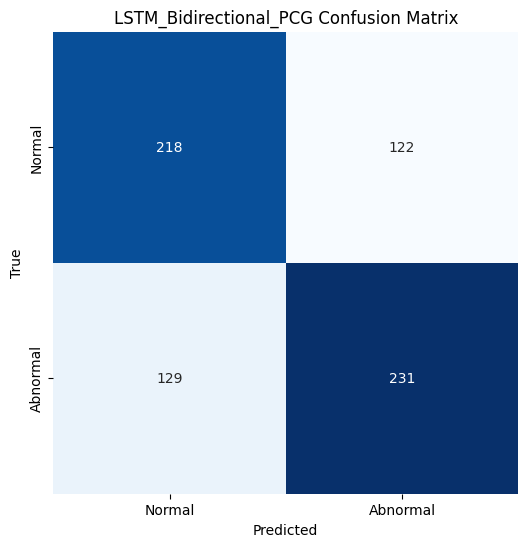

LSTM_Bidirectional_PCG Classification Report:
              precision    recall  f1-score   support

      Normal       0.63      0.64      0.63       340
    Abnormal       0.65      0.64      0.65       360

    accuracy                           0.64       700
   macro avg       0.64      0.64      0.64       700
weighted avg       0.64      0.64      0.64       700



In [20]:
feature_slice = slice(2, 6)
X_train_input = X_train_segmented[:, :, feature_slice]
X_test_input = X_test_segmented[:, :, feature_slice]
input_shape = X_train_input.shape[1:]

# Bidirectional LSTM
bilstm_model_pcg = build_lstm_model(input_shape, bidirectional=True)
train_and_evaluate(bilstm_model_pcg, X_train_input, y_train_segmented, X_test_input, y_test_segmented, "LSTM_Bidirectional_PCG")

### Training 3: Modify achitecture

In [39]:
# Build the LSTM model
def build_lstm_model_2CH(timesteps, features_ecg, features_pcg):
    # ECG input branch
    input_ecg = Input(shape=(timesteps, features_ecg))
    lstm_ecg = Bidirectional(LSTM(64, return_sequences=True))(input_ecg)
    lstm_ecg = Bidirectional(LSTM(128, return_sequences=False))(lstm_ecg)

    # PCG input branch
    input_pcg = Input(shape=(timesteps, features_pcg))
    lstm_pcg = Bidirectional(LSTM(64, return_sequences=True))(input_pcg)
    lstm_pcg = Bidirectional(LSTM(128, return_sequences=False))(lstm_pcg)

    # Concatenate the outputs of the two LSTM branches
    combined = Concatenate()([lstm_ecg, lstm_pcg])

    # Fully connected layers for classification
    # L2 Avoid overfitting by adds a Penalty to the Loss Function
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
    dropout = Dropout(0.3)(dense)
    output = Dense(1, activation='sigmoid')(dropout)  # Binary classification (0 or 1)

    # Build the model
    model = Model(inputs=[input_ecg, input_pcg], outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=1e-04)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.layers import BatchNormalization

def build_lstm_model_2CH_improved(timesteps, features_ecg, features_pcg):
    # ECG branch
    input_ecg = Input(shape=(timesteps, features_ecg))
    x_ecg = Conv1D(32, kernel_size=5, activation="relu", padding="same")(input_ecg)
    x_ecg = BatchNormalization()(x_ecg)
    x_ecg = Bidirectional(LSTM(64, return_sequences=True))(x_ecg)
    x_ecg = Bidirectional(LSTM(64, return_sequences=False))(x_ecg)

    # PCG branch
    input_pcg = Input(shape=(timesteps, features_pcg))
    x_pcg = Conv1D(32, kernel_size=5, activation="relu", padding="same")(input_pcg)
    x_pcg = BatchNormalization()(x_pcg)
    x_pcg = Bidirectional(LSTM(64, return_sequences=True))(x_pcg)
    x_pcg = Bidirectional(LSTM(64, return_sequences=False))(x_pcg)

    # Fusion
    combined = Concatenate()([x_ecg, x_pcg])
    dense = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(combined)
    dense = BatchNormalization()(dense)
    dense = Dropout(0.3)(dense)
    output = Dense(1, activation="sigmoid")(dense)

    model = Model(inputs=[input_ecg, input_pcg], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy", "AUC"])
    return model


# Create the model
model = build_lstm_model_2CH_improved(segment_length, features_ecg=2, features_pcg=4)

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# class_weight = {0: 3.0, 1: 1.0}

X_train_ecg = X_train_segmented[:,:,0:2]
X_train_pcg = X_train_segmented[:,:,2:6]
X_test_ecg = X_test_segmented[:,:,0:2]
X_test_pcg = X_test_segmented[:,:,2:6]

# Train the model with callbacks and class weights
history = model.fit([X_train_ecg, X_train_pcg], y_train_segmented,
                    epochs=50, batch_size=200,
                    validation_data=([X_test_ecg, X_test_pcg], y_test_segmented),
                    callbacks=[early_stopping, reduce_lr],
                    # class_weight=class_weight,
                    shuffle = True)

# Saving the model
model.save('LSTM_.h5')

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 200, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 200, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 200, 32)   │        352 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 200, 32)   │        672 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 32)   │        128 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 32)   │        128 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_50    │ (None, 200, 128)  │     49,664 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_52    │ (None, 200, 128)  │     49,664 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_51    │ (None, 128)       │     98,816 │ bidirectional_50… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_53    │ (None, 128)       │     98,816 │ bidirectional_52… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 256)       │          0 │ bidirectional_51… │
│ (Concatenate)       │                   │            │ bidirectional_53… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1)         │        129 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 331,777 (1.27 MB)

 Trainable params: 331,393 (1.26 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - AUC: 0.5188 - accuracy: 0.5159 - loss: 2.5316 - val_AUC: 0.5223 - val_accuracy: 0.4914 - val_loss: 2.3725 - learning_rate: 1.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - AUC: 0.6265 - accuracy: 0.5987 - loss: 2.3788 - val_AUC: 0.5563 - val_accuracy: 0.5057 - val_loss: 2.3441 - learning_rate: 1.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - AUC: 0.6487 - accuracy: 0.6224 - loss: 2.3313 - val_AUC: 0.5711 - val_accuracy: 0.5143 - val_loss: 2.3155 - learning_rate: 1.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - AUC: 0.6690 - accuracy: 0.6173 - loss: 2.2822 - val_AUC: 0.5897 - val_accuracy: 0.5400 - val_loss: 2.2868 - learning_rate: 1.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - AUC: 0.7054 - accuracy: 0.6516 - loss: 2.2205 - val_AUC: 0.5930 - val_accuracy: 0.5657 - val_loss: 2.2583 - learning_rate: 1.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - AUC: 0.7

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc, _ = model.evaluate([X_test_ecg, X_test_pcg], y_test_segmented, return_dict=True).values()
print(f"Test accuracy: {test_acc:.4f} , Test loss: {test_loss:.4f}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
y_pred = (model.predict([X_test_ecg, X_test_pcg]) > 0.5).astype(int)

cm = confusion_matrix(y_test_segmented, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test_segmented, y_pred, target_names=["Normal", "Abnormal"]))